# Fit baseline model using flight delay averages

- Takes the model input data for flight delays
- Split data based on external train/test data file
- Define baseline average model
- Evaluate model
- Save model as pickle
- -- save to mlflow -- 
- Write prediction prediction output to csv

### Parameters

-------------------

- input_file: Filepath of model input data of flight delays
- train_test_file: Filepath of train/test csv file with columns ["id", "model_set"]
- output_file: Filepath to write output csv file with minimal modelling input


### Returns

-----------------

Trained baseline model that simply predicts the average flight delay from the training
data in all predictions.


In [42]:
# model params
input_file = "../lvt-schiphol-assignment-snakemake/data/model_input/delays_base_input.csv"
train_test_file = "../lvt-schiphol-assignment-snakemake/data/model_input/train_test__0.2__sample.csv"
output_predictions = "./predictions.csv"

# mlflow params
log_mlflow = True
mlflow_tracking_uri = "../mlruns"
mlflow_experiment = "from_script"
mlflow_run = "baseline_avg"

In [43]:
from pathlib import Path
output_dir = Path(output_predictions).parent.absolute()
output_dir

WindowsPath('C:/Users/lodew/qualogy/schiphol-code-assignment/scripts')

#### Imports

In [44]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin

import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append("../")

from src.data.google_storage_io import read_csv_data, write_csv_data
from src.evaluation.metrics import get_regression_metrics
from src.evaluation.regression import make_regression_metrics_by_group, make_regression_metrics_by_datetime
from src.evaluation.predictions import make_predictions_dataframe

In [45]:
plt.rcParams["figure.figsize"] = (16, 8)

### Read data

In [46]:
%%time
df = read_csv_data(input_file)
train_test = read_csv_data(train_test_file)

Reading file from local directory
File:	../lvt-schiphol-assignment-snakemake/data/model_input/delays_base_input.csv

Reading file from local directory
File:	../lvt-schiphol-assignment-snakemake/data/model_input/train_test__0.2__sample.csv

Wall time: 727 ms


In [47]:
%%time

def split_train_test(df, train_test, target="scheduleDelaySeconds"):
    # merge by `id` and group by train/test set labels
    df_set_groups = pd.merge(df, train_test, on="id", how="left").groupby("model_set")
    
    # get data per train/test set
    df_train, df_test = df_set_groups.get_group("train"), df_set_groups.get_group("test")
    
    # split target from features
    X_train, y_train = df_train.drop(columns=[target]), df_train[target]
    X_test, y_test = df_test.drop(columns=[target]),  df_test[target]
    
    print(f"""
        Split data shapes
        Input: {df.shape}
        Train: {X_train.shape},\t {y_train.shape} 
        Test:  {X_test.shape},\t {y_test.shape}
        """)
    
    # assert that we haven't dropped values at this stage
    # failed assert could indicate duplicate ids found in the data
    assert (len(X_train) + len(X_test)) == len(df)
    
    return X_train, X_test, y_train, y_test

# split data
X_train, X_test, y_train, y_test = split_train_test(df, train_test)




        Split data shapes
        Input: (477776, 8)
        Train: (382220, 8),	 (382220,) 
        Test:  (95556, 8),	 (95556,)
        
Wall time: 536 ms


### Prediction model

#### Define model

In [48]:
class AverageBaseline(BaseEstimator):
    def __init__(self):
        self._average_y = None
   
    @property
    def average_y(self):
        return self._average_y
    
    def fit(self, X, y):
        """calculate the average values of `y` and save  internally"""
        self._average_y = np.mean(y)
        return self
    
    def predict(self, X):
        """return trained average y value for all observations in X"""
        return np.array([self.average_y] * X.shape[0])

#### Train model

In [49]:
# train
avg_baseline = AverageBaseline().fit(X_train, y_train)

#### Evaluate model

In [50]:
def datetime_to_date(dt):
    return pd.to_datetime(dt, utc=True).dt.date

def datetime_to_date_hour(dt):
    return pd.to_datetime(dt, utc=True).dt.floor('H')


In [51]:
# create predictions on train/test sets
df_predictions = make_predictions_dataframe(avg_baseline, X_train, X_test, y_train, y_test)
df_predictions

,id,scheduleDateTime,y,yhat,error,model_set
1,123414479288269149,2018-01-01 06:00:00+01:00,-98.0,859.825258,957.825258,train
2,123414479666542945,2018-01-01 06:05:00+01:00,-300.0,859.825258,1159.825258,train
5,123414479666545913,2018-01-01 06:20:00+01:00,611.0,859.825258,248.825258,train
6,123414478696233855,2018-01-01 06:20:00+01:00,611.0,859.825258,248.825258,train
7,123414479288370681,2018-01-01 06:20:00+01:00,180.0,859.825258,679.825258,train
...,...,...,...,...,...,...
477742,124763275285891683,2018-07-12 17:15:00+02:00,115.0,859.825258,744.825258,test
477748,124763299563775951,2018-07-12 17:15:00+02:00,-144.0,859.825258,1003.825258,test
477761,124763272032454817,2018-07-12 17:20:00+02:00,423.0,859.825258,436.825258,test
477765,124763271776654663,2018-07-12 17:25:00+02:00,80.0,859.825258,779.825258,test


#### Calculate regression metrics

In [52]:
%%time

df_metrics_long = make_regression_metrics_by_group(df_predictions, group_cols = ["model_set"])
df_daily_metrics_long = make_regression_metrics_by_datetime(df_predictions, freq="D", alias="schedule_date")
df_hourly_metrics_long = make_regression_metrics_by_datetime(df_predictions, freq="H", alias="schedule_date")

Wall time: 15.2 s


In [53]:
df_metrics_long.head()

,model_set,variable,value
0,test,mae,889.598834
1,train,mae,886.865285
2,test,mape,103.462747
3,train,mape,103.144828
4,test,rmse,2273.616920


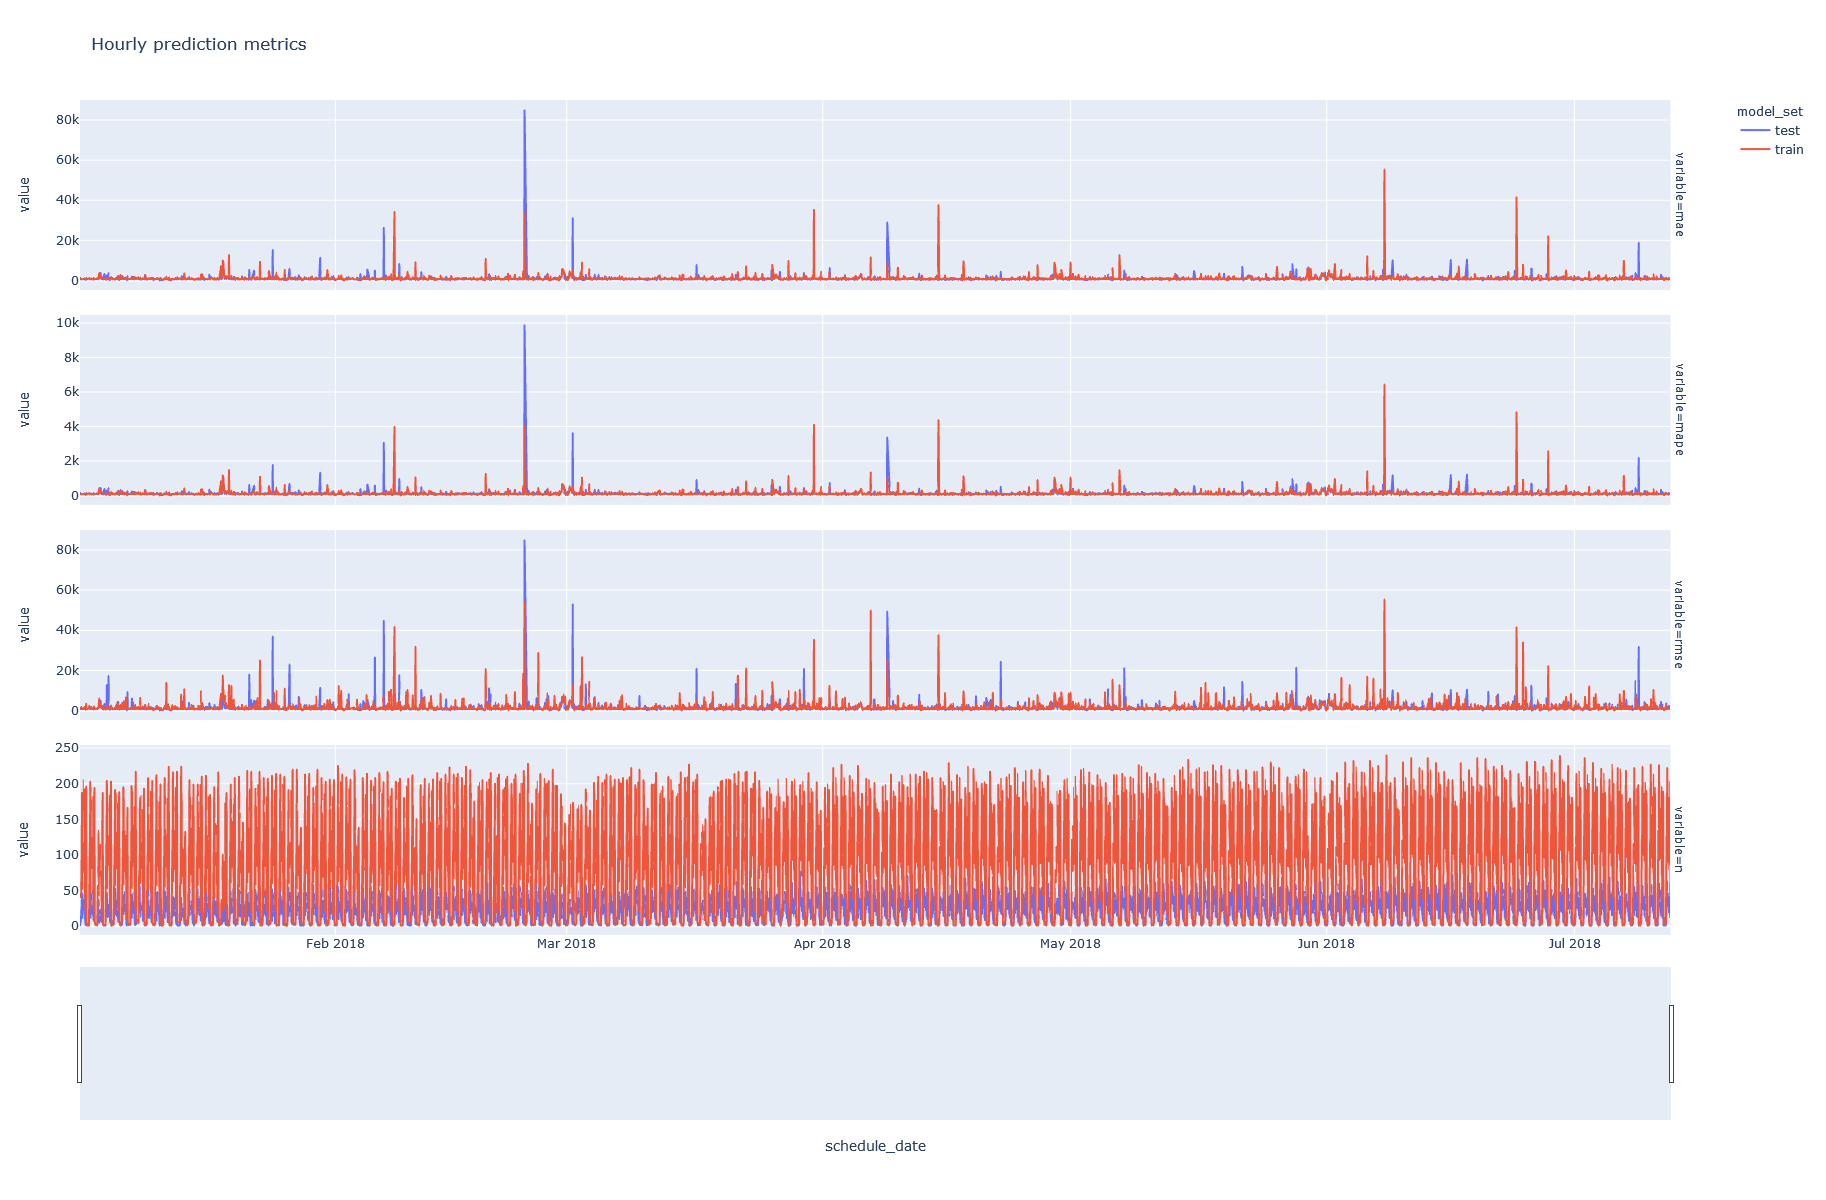

In [54]:
import plotly.express as px
fig = px.line(df_hourly_metrics_long, x="schedule_date", y="value", facet_row="variable", color="model_set",
             width=1200, height=1200, title="Hourly prediction metrics")
# Add range slider
fig.update_layout(
    xaxis=dict(
        rangeslider=dict(
            visible=True
        ),
        type="date"
    ),
    hovermode="x"
)
fig.update_yaxes(matches=None)
# fig.update_xaxes(matches=None)
fig.show()

### Plot some prediction results

In [55]:
# def predictions_daily_mean(df_predictions):
#     df_predictions["schedule_date"] = datetime_to_date(df_predictions["scheduleDateTime"])
#     df_predictions = df_predictions.drop(columns="id")
#     df_daily_mean = df_predictions.groupby(["model_set", "schedule_date"]).mean().reset_index()
#     return df_daily_mean

# def predictions_hourly_mean(df_predictions):
#     df_predictions["schedule_date"] = datetime_to_date_hour(df_predictions["scheduleDateTime"])
#     df_predictions = df_predictions.drop(columns="id")
#     df_daily_mean = df_predictions.groupby(["model_set", "schedule_date"]).mean().reset_index()
#     return df_daily_mean

# def get_safe_ylim(y, q=0.05, q2=None):
#     if q2 is None:
#         q2 = 1 - q
#     return (np.quantile(y, q), np.quantile(y, q2))


# df_daily_mean = predictions_daily_mean(df_predictions)
# y_ylim = get_safe_ylim(df_daily_mean["y"])
# error_ylim = get_safe_ylim(df_daily_mean["error"])

# df_daily_mean[["schedule_date", "y", "yhat"]].plot(x="schedule_date", ylim=y_ylim)
# df_daily_mean[["schedule_date", "error"]].plot(x="schedule_date", ylim=error_ylim)

# df_hourly_mean = predictions_hourly_mean(df_predictions)
# y_ylim = get_safe_ylim(df_hourly_mean["y"])
# error_ylim = get_safe_ylim(df_hourly_mean["error"])

# df_hourly_mean[["schedule_date", "y", "yhat"]].plot(x="schedule_date", ylim=y_ylim)
# df_hourly_mean[["schedule_date", "error"]].plot(x="schedule_date", ylim=error_ylim)

### Write output to output directory

In [56]:
import joblib, pickle
from pathlib import Path

In [58]:
model_file = str(Path(output_dir, "model.pkl"))
predictions_file = str(Path(output_dir, "predictions.csv"))
overall_metrics_file = str(Path(output_dir, "overall_metrics_long.csv"))
daily_metrics_file = str(Path(output_dir, "daily_metrics_long.csv"))
hourly_metrics_file = str(Path(output_dir, "hourly_metrics_long.csv"))

### Pickle output files for mlflow artifacts

- Pipeline serialized with `joblib`
- Model data or sample thereof 



In [57]:
joblib.dump(avg_baseline, model_file) 

['C:\\Users\\lodew\\qualogy\\schiphol-code-assignment\\scripts\\model.pkl']

### Write output to CSV

Local or Google Storage is both handled

In [59]:
# write output file
write_csv_data(df_predictions,       predictions_file, index=False)
write_csv_data(df_metrics_long,       overall_metrics_file, index=False)
write_csv_data(df_daily_metrics_long, daily_metrics_file, index=False)
write_csv_data(df_hourly_metrics_long, hourly_metrics_file, index=False)

Writing file to local directory
File:	C:\Users\lodew\qualogy\schiphol-code-assignment\scripts\predictions.csv

Writing file to local directory
File:	C:\Users\lodew\qualogy\schiphol-code-assignment\scripts\overall_metrics_long.csv

Writing file to local directory
File:	C:\Users\lodew\qualogy\schiphol-code-assignment\scripts\daily_metrics_long.csv

Writing file to local directory
File:	C:\Users\lodew\qualogy\schiphol-code-assignment\scripts\hourly_metrics_long.csv



### Log to mlflow

In [60]:
import mlflow

mlflow.set_tracking_uri(mlflow_tracking_uri)
mlflow.set_experiment(mlflow_experiment)


print(f"Logging to experiment: {mlflow_experiment}")
print(f"Run name: {mlflow_run}")

with mlflow.start_run(run_name=mlflow_run):
    mlflow.log_param("Input file", input_file)
    mlflow.log_param("Train-test file", train_test_file)
    
    # Model metadata
    for idx, metric_row in df_metrics_long.iterrows():
        metric_name = "__".join([metric_row["variable"], metric_row["model_set"]])
        mlflow.log_metric(metric_name, metric_row["value"])
    
    # log artifacts
    print("Logging artifacts")
    mlflow.log_artifact(model_file)
    mlflow.log_artifact(predictions_file)
    mlflow.log_artifact(overall_metrics_file)
    mlflow.log_artifact(daily_metrics_file)
    mlflow.log_artifact(hourly_metrics_file)
    


Logging to experiment: test_baseline_average
Run name: baseline_avg
Logging artifacts


### Overview of the output data

In [61]:
df_predictions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 477776 entries, 1 to 477775
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype              
---  ------            --------------   -----              
 0   id                477776 non-null  int64              
 1   scheduleDateTime  477776 non-null  object             
 2   y                 477776 non-null  float64            
 3   yhat              477776 non-null  float64            
 4   error             477776 non-null  float64            
 5   model_set         477776 non-null  object             
 6   schedule_date     477776 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), float64(3), int64(1), object(2)
memory usage: 29.2+ MB
